In [60]:
import pandas as pd
import anndata as ad
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import os.path as osp
import os
import pickle as pkl
import kneed
import gseapy as gp
from scipy.stats import spearmanr

Define helper functions

In [21]:
def collate_results(beta_dict, receiver, sender, remove_nans = True):
    ics = dict()
    for pat in beta_dict.keys():
        try:
            ic = beta_dict[pat].loc[receiver,sender]['beta']#.sort_values(ascending = False)
            ics[pat] = ic
        except:
            pass
    ics_df = pd.DataFrame(ics)
    if remove_nans:
        ics_df = ics_df.iloc[~np.any(np.isnan(ics_df.values),axis=1)]
    return ics_df


def get_top_ranked(sorted_values, S =5):
    
    kneed_x = np.arange(len(sorted_values))
    if isinstance(sorted_values, pd.DataFrame):
        kneed_y = sorted_values.values
    else:
        kneed_y = sorted_values
        
    kneedle = kneed.KneeLocator(kneed_x, kneed_y, S=S, curve="convex", direction="decreasing")
    

    return kneedle.knee, kneedle.knee_y

Get output and results directory

In [17]:
with open('../paper_analysis_notebooks/OUTPUT_DIR.txt','r+') as f:
    OUTPUT_ROOT = f.readlines()[0]

OUTPUT_DIR = osp.join(OUTPUT_ROOT, 'mac_treg')

os.makedirs(OUTPUT_DIR, exist_ok = True)

Load interaction coefficients

In [12]:
with open(osp.join(OUTPUT_DIR,'beta_res.pkl'), 'rb') as f:
        beta_res = pkl.load(f)

Get the interaction coefficients across all patients for the interaction `Mac <- Treg` and `Treg <- Mac` 

In [18]:
mac_treg_ics = collate_results(beta_dict=beta_res, receiver = 'Mac', sender = 'Treg')
treg_mac_ics = collate_results(beta_dict=beta_res, sender = 'Mac', receiver = 'Treg')

mac_treg_mean = mac_treg_ics.mean(axis=1).sort_values(ascending = False)
treg_mac_mean = treg_mac_ics.mean(axis=1).sort_values(ascending = False)

Get the top genes for each interaction using the kneed algorithm

In [23]:
mac_treg_top_xy = get_top_ranked(mac_treg_mean)
treg_mac_top_xy = get_top_ranked(treg_mac_mean)

mac_treg_top = [x.upper() for x in mac_treg_mean.index[0:mac_treg_top_xy[0]]]
treg_mac_top = [x.upper() for x in treg_mac_mean.index[0:treg_mac_top_xy[0]]]

In [25]:
print(f'Gene list size: {len(mac_treg_top)} Mac <-Treg | Treg <- Mac {len(treg_mac_top)}')

Gene list size: 259 Mac <-Treg | Treg <- Mac 349


Plot the cutoff

In [36]:
mac_treg_mean.values

array([ 32.83172933,  29.89410931,  27.01171615, ..., -23.31065972,
       -27.82255889, -38.53832955])

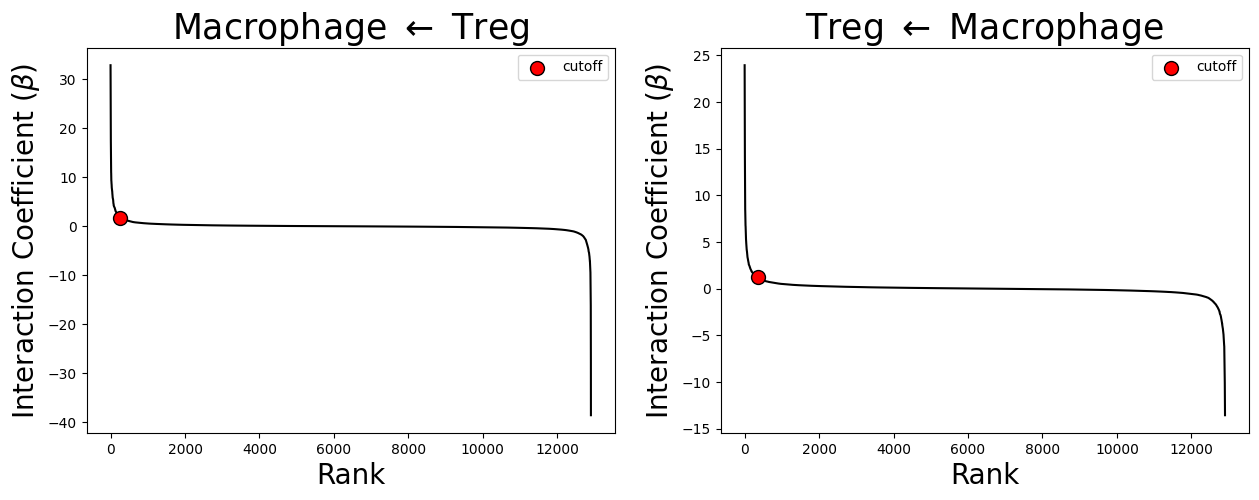

In [41]:

plt.figure(figsize=(15,5))
plt.subplot(121)

plt.plot(mac_treg_mean.values, color = 'black', zorder = -100)
plt.scatter(*mac_treg_top_xy, c = 'red', edgecolor = 'black', label = 'cutoff', s = 100)
plt.ylabel(r'Interaction Coefficient ($\beta$)', fontsize = 20)
plt.xlabel('Rank', fontsize = 20)
plt.title(r'Macrophage $\leftarrow$ Treg', fontsize = 25)
plt.legend()

plt.subplot(122)
plt.plot(treg_mac_mean.values, color = 'black', zorder = -100)
plt.scatter(*treg_mac_top_xy, c = 'red', edgecolor = 'black', label = 'cutoff', s = 100)
plt.ylabel(r'Interaction Coefficient ($\beta$)', fontsize = 20)
plt.xlabel('Rank', fontsize = 20)
plt.title(r'Treg $\leftarrow$ Macrophage', fontsize = 25)
plt.legend()


plt.show()

In [ ]:
Save results

In [ ]:
with open(osp.join(OUTPUT_DIR, 'mac_treg_sig.txt'),'w+') as f:
    f.writelines(', '.join(mac_treg_top))

with open(osp.join(OUTPUT_DIR, 'treg_mac_sig.txt'),'w+') as f:
    f.writelines(', '.join(treg_mac_top))

Do an enrichment analysis

In [30]:
mac_treg_enr = gp.enrichr(gene_list=mac_treg_top, gene_sets='MSigDB_Hallmark_2020', organism = 'human').results
treg_mac_enr = gp.enrichr(gene_list=treg_mac_top, gene_sets='MSigDB_Hallmark_2020', organism = 'human').results

for enr in [mac_treg_enr, treg_mac_enr]:
    enr[enr['Adjusted P-value'].values < 0.01]

Inspect top results for each interaction

In [31]:
mac_treg_enr[['Term','Overlap','Adjusted P-value','Genes']].head(10)

,Term,Overlap,Adjusted P-value,Genes
0,Interferon Gamma Response,28/200,2.503837e-19,IFITM3;SAMD9L;CXCL9;FGL2;UBE2L6;IFI35;IFIT3;IF...
1,Interferon Alpha Response,20/97,2.165844e-17,IFITM3;SAMD9L;SAMD9;MX1;TAP1;HLA-C;UBE2L6;ISG1...
2,Complement,18/200,2.030443e-09,FCER1G;PLA2G7;CTSS;ATOX1;PSMB9;LGALS3;PLSCR1;C...
3,TNF-alpha Signaling via NF-kB,17/200,1.221167e-08,DUSP1;TAP1;CFLAR;ATP2B1;CXCL3;SOD2;SAT1;CXCL2;...
4,Allograft Rejection,16/200,7.335898e-08,EIF5A;CCL13;NPM1;CXCL9;SPI1;IGSF6;CCL22;IFNGR1...
5,Apoptosis,14/161,1.867785e-07,IFITM3;ANXA1;IFNGR1;TAP1;CFLAR;SOD2;SAT1;ISG20...
6,mTORC1 Signaling,12/200,8.049469e-05,ACTR2;RAB1A;PPA1;PRDX1;FGL2;TCEA1;CALR;CORO1A;...
7,IL-6/JAK/STAT3 Signaling,7/87,7.834668e-04,CXCL10;CXCL9;CXCL11;IFNGR1;STAT1;CXCL3;IL13RA1
8,Inflammatory Response,10/200,1.488608e-03,CXCL10;CXCL11;CXCL9;GNA15;CCL22;RGS1;ADM;ATP2B...
9,Reactive Oxygen Species Pathway,5/49,1.930206e-03,PRDX1;LSP1;SOD2;ATOX1;FTL


In [32]:
treg_mac_enr[['Term','Overlap','Adjusted P-value','Genes']].head(10)

,Term,Overlap,Adjusted P-value,Genes
0,Myc Targets V1,40/200,3.993322e-29,EIF4A1;PCNA;HSP90AB1;MCM7;GLO1;SRSF1;PHB;TYMS;...
1,Oxidative Phosphorylation,24/200,2.696573e-12,COX8A;HSPA9;TIMM8B;MRPS15;ATP6V0B;ATP6V0E1;NDU...
2,mTORC1 Signaling,21/200,8.359357e-10,HSPA9;FKBP2;TPI1;INSIG1;CXCR4;CACYBP;ENO1;HSPE...
3,E2F Targets,18/200,1.785286e-07,RANBP1;DUT;PCNA;MCM7;TUBB;SRSF1;HMGB2;NAP1L1;S...
4,DNA Repair,14/150,3.708619e-06,BCAP31;DUT;PCNA;ARL6IP1;ADRM1;EDF1;SSRP1;TYMS;...
5,IL-2/STAT5 Signaling,14/199,6.973332e-05,CD83;AHNAK;GSTO1;IL1R2;TNFRSF18;CST7;BATF;SYNG...
6,TNF-alpha Signaling via NF-kB,14/200,6.973332e-05,EGR1;JUN;CD83;PLAUR;NFKBIA;NR4A2;ZFP36;MARCKS;...
7,Glycolysis,14/200,6.973332e-05,TPI1;MDH1;TALDO1;CXCR4;ENO1;LDHA;PKM;NASP;GPC1...
8,Hypoxia,13/200,2.470295e-04,JUN;TPI1;PLAUR;CXCR4;ENO1;LDHA;ZFP36;GPC1;DDIT...
9,Allograft Rejection,13/200,2.470295e-04,EIF5A;CXCL9;CCL22;HLA-A;IL2RG;CTSS;HLA-E;NME1;...


### TCGA Analysis

Define paths to TCGA data

In [43]:
rna_seq_paths = dict(SKCM = '../../data/tcga/skcm/skcm_tcga_pan_can_atlas_2018/data_mrna_seq_v2_rsem_zscores_ref_all_samples.txt',
                     HNSC = '../../data/tcga/hnsc/hnsc_tcga_gdc/data_mrna_seq_fpkm_zscores_ref_all_samples.txt',
                     LUAD = '../../tcga/lung_squam/lusc_tcga/data_mrna_seq_v2_rsem_zscores_ref_all_samples.txt',
                    )

clin_paths = dict(SKCM = '../../data/tcga/skcm/skcm_tcga_pan_can_atlas_2018/data_clinical_patient.txt',
                  HNSC = '../../data/tcga/hnsc/hnsc_tcga_gdc/data_clinical_patient.txt',
                  LUAD = '../../data/tcga/lung_squam/lusc_tcga/data_clinical_patient.txt',
                 )

Specify which disease to analyze (default should be SKCM)

In [44]:
disease = 'SKCM'
rna_seq_path = rna_seq_paths[disease]
clin_path = clin_paths[disease]

Load the RNA-seq data

In [45]:
rna_seq_df = pd.read_csv(rna_seq_path, sep = '\t', index_col = 0, header=0).T
rna_seq_df = rna_seq_df.iloc[:,~rna_seq_df.columns.isna()]
if 'Entrez_Gene_Id' in rna_seq_df.index:
    rna_seq_df = rna_seq_df.drop(index='Entrez_Gene_Id')

Inspect RNA-seq data to make sure it looks ok

In [46]:
rna_seq_df

Hugo_Symbol,UBE2Q2P2,HMGB1P1,RNU12-2P,SSX9P,EZHIP,EFCAB8,SRP14P1,TRIM75P,SPATA31B1P,REXO1L6P,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
TCGA-3N-A9WB-06,0.2287,0.1120,0.3088,-1.1674,-0.7776,-1.3053,-0.6906,-1.4953,-2.8793,NaN,...,0.2795,1.5289,-1.4791,-1.0775,-0.5874,0.7428,-0.2728,-2.0876,-2.2139,-0.1152
TCGA-3N-A9WC-06,0.4992,-0.9303,-0.6854,-1.1674,-0.5525,0.2834,-0.2565,-1.4953,-2.8793,NaN,...,-0.0489,-0.5350,0.5245,0.2616,0.3533,-0.7334,-0.1408,-0.3072,-1.2198,0.6850
TCGA-3N-A9WD-06,-0.3667,-0.2610,-2.0036,-1.1674,-0.6006,0.1596,-0.9029,-1.4953,-2.8793,NaN,...,-1.2839,-0.5780,-0.6422,-0.2198,0.6876,1.4183,0.2610,-0.4649,-0.5828,-0.0017
TCGA-BF-A1PU-01,-2.6079,-0.7479,-2.0036,-0.6248,-1.0828,0.4881,1.2143,-1.4953,-2.8793,NaN,...,-0.0670,-0.0718,-0.1132,-0.1148,0.3637,-1.3046,-1.0278,0.2870,0.7965,-1.7373
TCGA-BF-A1PV-01,-0.5174,0.3751,-2.0036,-1.1674,-1.0828,-1.3053,0.3070,-1.4953,-2.8793,NaN,...,0.5413,0.4944,0.6672,0.3759,-0.7236,-1.3046,0.5597,0.2858,-0.6041,1.3473
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-YG-AA3O-06,0.4808,-1.1468,1.8607,-1.1674,-1.0828,-1.3053,-1.3256,-1.4953,-2.8793,NaN,...,0.1494,0.7134,1.0511,0.6257,0.0850,-0.6262,0.5643,-0.5405,1.9254,0.3507
TCGA-YG-AA3P-06,-0.8263,-0.6525,-0.3357,-1.1674,-1.0828,0.5880,-1.0679,-1.4953,-2.8793,NaN,...,0.1292,-0.7866,-0.0144,0.1821,-1.6252,-1.3046,0.4194,-1.3487,0.2471,0.4648
TCGA-Z2-A8RT-06,-0.8194,-0.5254,0.2377,-1.1674,0.9449,-0.3533,0.0460,-1.4953,-2.8793,NaN,...,0.6918,0.9792,0.8877,1.1734,1.3201,-0.2602,-0.8492,-0.6856,0.8800,-0.9265
TCGA-Z2-AA3S-06,-0.5153,-0.2297,-1.0152,-1.1674,-0.6736,-0.5507,-0.9442,-0.7698,-2.8793,NaN,...,0.3677,-0.1656,0.9342,1.1056,-1.9422,-1.3046,1.5201,-1.1748,0.5387,1.1137


Convert Entrez IDs to Gene names if necessary

In [47]:
if 'entrez' in rna_seq_df.columns.name.lower():
    conv = pd.read_csv('../../data/imod/tcga/hgnc_complete_set_2024-10-01.txt', sep = '\t')
    conv['entrez_id_fix'] = conv['entrez_id'].values.astype(int).astype(str)
    entrez_to_hgnc = conv[['symbol','entrez_id_fix']]
    entrez_to_hgnc.index = entrez_to_hgnc['entrez_id_fix']
    
    rna_seq_df.columns = rna_seq_df.columns.astype(str)
    inter =entrez_to_hgnc.index.intersection(rna_seq_df.columns)
    rna_seq_df = rna_seq_df.loc[:,inter]
    rna_seq_df.columns = entrez_to_hgnc.loc[inter,'symbol']

rna_seq_df

Hugo_Symbol,UBE2Q2P2,HMGB1P1,RNU12-2P,SSX9P,EZHIP,EFCAB8,SRP14P1,TRIM75P,SPATA31B1P,REXO1L6P,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
TCGA-3N-A9WB-06,0.2287,0.1120,0.3088,-1.1674,-0.7776,-1.3053,-0.6906,-1.4953,-2.8793,NaN,...,0.2795,1.5289,-1.4791,-1.0775,-0.5874,0.7428,-0.2728,-2.0876,-2.2139,-0.1152
TCGA-3N-A9WC-06,0.4992,-0.9303,-0.6854,-1.1674,-0.5525,0.2834,-0.2565,-1.4953,-2.8793,NaN,...,-0.0489,-0.5350,0.5245,0.2616,0.3533,-0.7334,-0.1408,-0.3072,-1.2198,0.6850
TCGA-3N-A9WD-06,-0.3667,-0.2610,-2.0036,-1.1674,-0.6006,0.1596,-0.9029,-1.4953,-2.8793,NaN,...,-1.2839,-0.5780,-0.6422,-0.2198,0.6876,1.4183,0.2610,-0.4649,-0.5828,-0.0017
TCGA-BF-A1PU-01,-2.6079,-0.7479,-2.0036,-0.6248,-1.0828,0.4881,1.2143,-1.4953,-2.8793,NaN,...,-0.0670,-0.0718,-0.1132,-0.1148,0.3637,-1.3046,-1.0278,0.2870,0.7965,-1.7373
TCGA-BF-A1PV-01,-0.5174,0.3751,-2.0036,-1.1674,-1.0828,-1.3053,0.3070,-1.4953,-2.8793,NaN,...,0.5413,0.4944,0.6672,0.3759,-0.7236,-1.3046,0.5597,0.2858,-0.6041,1.3473
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-YG-AA3O-06,0.4808,-1.1468,1.8607,-1.1674,-1.0828,-1.3053,-1.3256,-1.4953,-2.8793,NaN,...,0.1494,0.7134,1.0511,0.6257,0.0850,-0.6262,0.5643,-0.5405,1.9254,0.3507
TCGA-YG-AA3P-06,-0.8263,-0.6525,-0.3357,-1.1674,-1.0828,0.5880,-1.0679,-1.4953,-2.8793,NaN,...,0.1292,-0.7866,-0.0144,0.1821,-1.6252,-1.3046,0.4194,-1.3487,0.2471,0.4648
TCGA-Z2-A8RT-06,-0.8194,-0.5254,0.2377,-1.1674,0.9449,-0.3533,0.0460,-1.4953,-2.8793,NaN,...,0.6918,0.9792,0.8877,1.1734,1.3201,-0.2602,-0.8492,-0.6856,0.8800,-0.9265
TCGA-Z2-AA3S-06,-0.5153,-0.2297,-1.0152,-1.1674,-0.6736,-0.5507,-0.9442,-0.7698,-2.8793,NaN,...,0.3677,-0.1656,0.9342,1.1056,-1.9422,-1.3046,1.5201,-1.1748,0.5387,1.1137


Merge samples from the same patient, clinical survival data is on a per-patient level

In [48]:
rna_seq_df['patient'] = ['-'.join(x.split('-')[0:-1]) for x in rna_seq_df.index]
rna_seq_df = rna_seq_df.groupby('patient').agg('mean')
rna_seq_df

Hugo_Symbol,UBE2Q2P2,HMGB1P1,RNU12-2P,SSX9P,EZHIP,EFCAB8,SRP14P1,TRIM75P,SPATA31B1P,REXO1L6P,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
patient,,,,,,,,,,,,,,,,,,,,,
TCGA-3N-A9WB,0.2287,0.1120,0.3088,-1.1674,-0.7776,-1.3053,-0.6906,-1.4953,-2.8793,NaN,...,0.2795,1.5289,-1.4791,-1.0775,-0.5874,0.7428,-0.2728,-2.0876,-2.2139,-0.1152
TCGA-3N-A9WC,0.4992,-0.9303,-0.6854,-1.1674,-0.5525,0.2834,-0.2565,-1.4953,-2.8793,NaN,...,-0.0489,-0.5350,0.5245,0.2616,0.3533,-0.7334,-0.1408,-0.3072,-1.2198,0.6850
TCGA-3N-A9WD,-0.3667,-0.2610,-2.0036,-1.1674,-0.6006,0.1596,-0.9029,-1.4953,-2.8793,NaN,...,-1.2839,-0.5780,-0.6422,-0.2198,0.6876,1.4183,0.2610,-0.4649,-0.5828,-0.0017
TCGA-BF-A1PU,-2.6079,-0.7479,-2.0036,-0.6248,-1.0828,0.4881,1.2143,-1.4953,-2.8793,NaN,...,-0.0670,-0.0718,-0.1132,-0.1148,0.3637,-1.3046,-1.0278,0.2870,0.7965,-1.7373
TCGA-BF-A1PV,-0.5174,0.3751,-2.0036,-1.1674,-1.0828,-1.3053,0.3070,-1.4953,-2.8793,NaN,...,0.5413,0.4944,0.6672,0.3759,-0.7236,-1.3046,0.5597,0.2858,-0.6041,1.3473
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-YG-AA3O,0.4808,-1.1468,1.8607,-1.1674,-1.0828,-1.3053,-1.3256,-1.4953,-2.8793,NaN,...,0.1494,0.7134,1.0511,0.6257,0.0850,-0.6262,0.5643,-0.5405,1.9254,0.3507
TCGA-YG-AA3P,-0.8263,-0.6525,-0.3357,-1.1674,-1.0828,0.5880,-1.0679,-1.4953,-2.8793,NaN,...,0.1292,-0.7866,-0.0144,0.1821,-1.6252,-1.3046,0.4194,-1.3487,0.2471,0.4648
TCGA-Z2-A8RT,-0.8194,-0.5254,0.2377,-1.1674,0.9449,-0.3533,0.0460,-1.4953,-2.8793,NaN,...,0.6918,0.9792,0.8877,1.1734,1.3201,-0.2602,-0.8492,-0.6856,0.8800,-0.9265


Load clinical data

In [49]:
# read data
clin_df = pd.read_csv(clin_path, sep = '\t', index_col=0)
# change column names to proper ones
clin_df.columns = clin_df.iloc[3]
# drop header meta data
clin_df = clin_df.iloc[4::]
# display
clin_df

PATIENT_ID,SUBTYPE,CANCER_TYPE_ACRONYM,OTHER_PATIENT_ID,AGE,SEX,AJCC_PATHOLOGIC_TUMOR_STAGE,AJCC_STAGING_EDITION,DAYS_LAST_FOLLOWUP,DAYS_TO_BIRTH,DAYS_TO_INITIAL_PATHOLOGIC_DIAGNOSIS,...,IN_PANCANPATHWAYS_FREEZE,OS_STATUS,OS_MONTHS,DSS_STATUS,DSS_MONTHS,DFS_STATUS,DFS_MONTHS,PFS_STATUS,PFS_MONTHS,GENETIC_ANCESTRY_LABEL
#Patient Identifier,,,,,,,,,,,,,,,,,,,,,
TCGA-3N-A9WB,SKCM,SKCM,5564E6A7-2195-4B0D-994E-B0617B58E889,71,Male,STAGE IA,7TH,NaN,-26176,0,...,Yes,1:DECEASED,17.02995036,1:DEAD WITH TUMOR,17.02995036,NaN,NaN,1:PROGRESSION,14.00532597,EUR
TCGA-3N-A9WC,SKCM,SKCM,551E071A-C290-4B48-9000-F64C2A44DFB7,82,Male,STAGE IIA,6TH,2022,-30286,0,...,Yes,0:LIVING,66.47598383,0:ALIVE OR DEAD TUMOR FREE,66.47598383,NaN,NaN,1:PROGRESSION,56.05418023,EUR
TCGA-3N-A9WD,SKCM,SKCM,A29A20E3-5C2C-4F37-B93E-AE9EBC46EC53,82,Male,STAGE IIIA,7TH,NaN,-30163,0,...,Yes,1:DECEASED,12.98615906,1:DEAD WITH TUMOR,12.98615906,NaN,NaN,1:PROGRESSION,10.06016372,EUR
TCGA-BF-A1PU,NaN,SKCM,3DD5A206-D7F3-42F1-B9CC-4B31C76D495D,46,Female,STAGE IIC,7TH,387,-17025,0,...,No,0:LIVING,12.72314824,0:ALIVE OR DEAD TUMOR FREE,12.72314824,NaN,NaN,1:PROGRESSION,15.91215439,EUR
TCGA-BF-A1PV,NaN,SKCM,EFF78AF6-0F68-49B9-866B-0D511606F2B1,74,Female,STAGE IIC,7TH,14,-27124,0,...,No,0:LIVING,0.460268929,0:ALIVE OR DEAD TUMOR FREE,0.460268929,NaN,NaN,0:CENSORED,0.460268929,EUR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-YG-AA3O,SKCM,SKCM,19E9BA4B-8F8E-4899-B667-B49FDD7EF6F4,62,Male,NaN,NaN,1096,-22999,0,...,Yes,1:DECEASED,37.93931025,1:DEAD WITH TUMOR,37.93931025,NaN,NaN,1:PROGRESSION,32.84347569,
TCGA-YG-AA3P,SKCM,SKCM,F1713C39-26B8-4667-A08B-F8CF6D2B8E13,63,Female,STAGE IIB,7TH,439,-23219,0,...,Yes,0:LIVING,14.43271855,0:ALIVE OR DEAD TUMOR FREE,14.43271855,NaN,NaN,0:CENSORED,14.43271855,
TCGA-Z2-A8RT,SKCM,SKCM,590B5E18-D837-4C0E-BECF-80520DB57C0F,42,Female,STAGE IIB,7TH,839,-15342,0,...,Yes,0:LIVING,27.58325936,0:ALIVE OR DEAD TUMOR FREE,27.58325936,NaN,NaN,0:CENSORED,27.58325936,EUR


Make sure Patient ID is set as index, to match RNA-seq data

In [50]:
if 'PATIENT_ID' in clin_df.columns:
    clin_df.index = clin_df['PATIENT_ID']

Align clinical and RNA-seq data

In [51]:
inter = clin_df.index.intersection(rna_seq_df.index)
clin_df = clin_df.loc[inter]
rna_seq_df = rna_seq_df.loc[inter]

Cast into AnnData object

In [52]:
adata = ad.AnnData(rna_seq_df)
adata.obs = clin_df.copy()
adata.var_names_make_unique()
adata = adata[:,~np.any(np.isnan(adata.X),axis=0)]

/gpfs/scratchfs01/site/u/andera29/micromamba/envs/telegraph/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


### Scoring

Score the RNA-seq data w.r.t the interaction coefficients from the interactions of interest

Read gene lists and score anndata

In [53]:
# how many bins should we split the score into
nbins = 4


with open(osp.join(OUTPUT_DIR,  'mac_treg_sig.txt'), 'r') as f:
    top_genes = f.readlines()[0].split(', ')
    top_genes = [x.rstrip('\n') for x in top_genes]

# score genes data
sc.tl.score_genes(adata,
                  gene_list=top_genes,
                  score_name='mac_treg_score',
                 )

# bin the scores
adata.obs[f'mac_treg_score_bin'] = pd.qcut(adata.obs[f'mac_treg_score'], nbins, labels=False)


# score genes data
sc.tl.score_genes(adata,
                  gene_list=['TNFRSF18'],
                  score_name='gitr_score',
                 )

# bin the scores
adata.obs[f'gitr_score_bin'] = pd.qcut(adata.obs[f'gitr_score'], nbins, labels=False)

/gpfs/scratchfs01/site/u/andera29/micromamba/envs/telegraph/lib/python3.10/site-packages/scanpy/tools/_score_genes.py:178: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[score_name] = pd.Series(


Visualize score (sanity check)

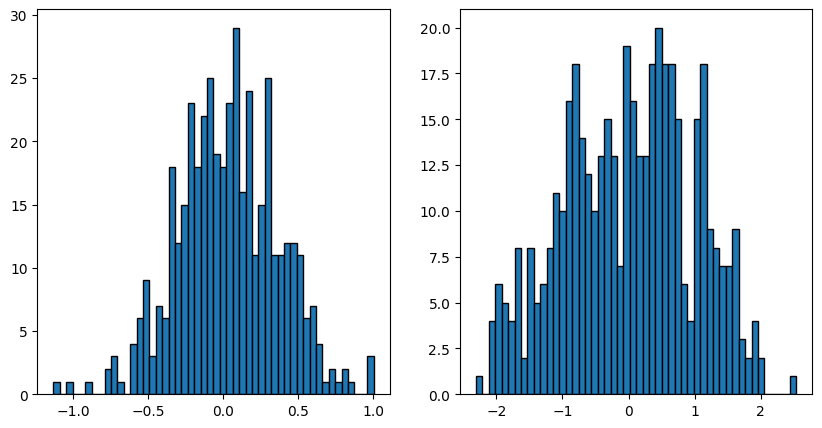

In [54]:
plt.figure(figsize = (10,5))
plt.subplot(121)
plt.hist(adata.obs['mac_treg_score'], bins = 50, edgecolor = 'black')
plt.subplot(122)
plt.hist(adata.obs['gitr_score'], bins = 50, edgecolor = 'black')
plt.show()


### Survival Analysis
Conduct the survival analysis

In [55]:
km_data = adata.obs.copy()

Format data, it's has mixed types and causes errors otherwise

In [56]:
# Map strings to numbers
km_data["OS_STATUS_BIN"] = km_data["OS_STATUS"].map({"1:DECEASED":1, "0:LIVING":0})
# convert to ints
km_data["OS_STATUS_BIN"] = (km_data["OS_STATUS_BIN"] == 1).astype(int)
# drop nans
km_data = km_data.iloc[~km_data[['OS_STATUS_BIN','OS_MONTHS']].isna().any(axis=1).values]

Clean up data

In [57]:
# "OS_MONTHS" values we want to drop
blacklist_months = ['[Not Available]']
# Find blacklisted values
drop_months = np.isin(km_data['OS_MONTHS'], blacklist_months)
# drop blacklisted values
km_data = km_data[~drop_months]

Generate survival curves and p-values

/tmp/ipykernel_1852682/59458269.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  survival_data[mask]["OS_STATUS_BIN"],
/tmp/ipykernel_1852682/59458269.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  survival_data[mask]["OS_MONTHS"], conf_type='log-log', conf_level=0.95,
/tmp/ipykernel_1852682/59458269.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  survival_data[mask]["OS_STATUS_BIN"],
/tmp/ipykernel_1852682/59458269.p

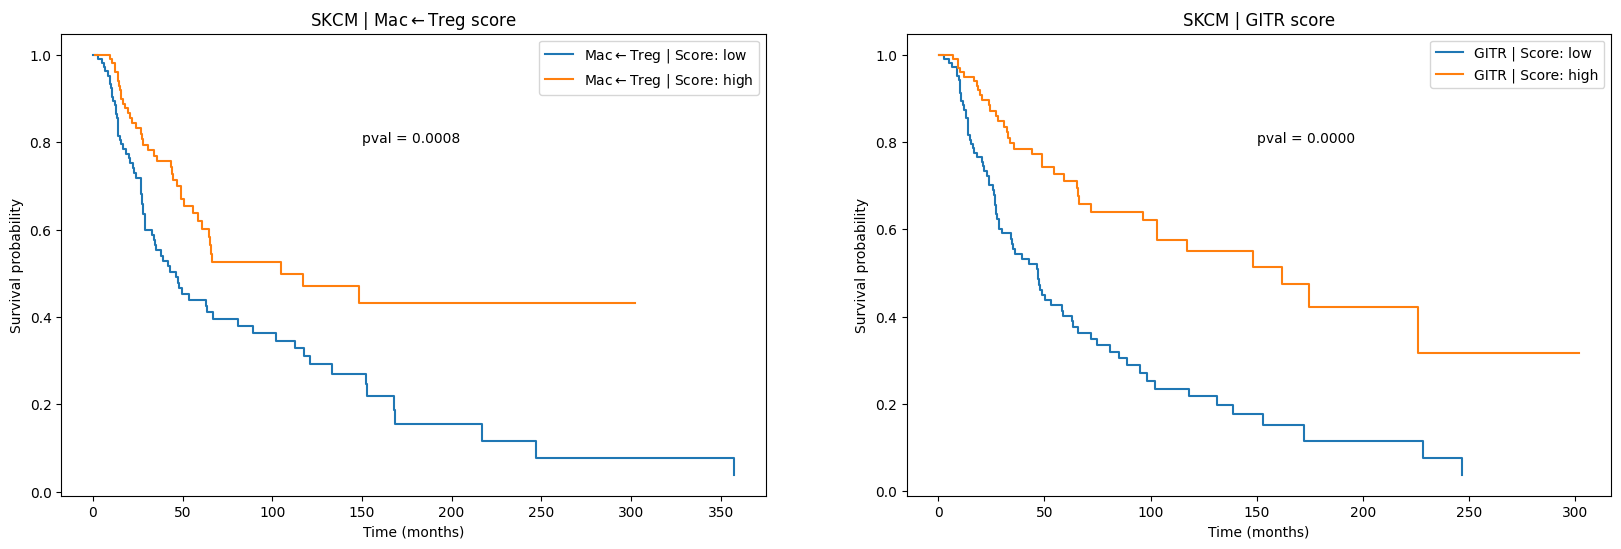

In [58]:
from sksurv.datasets import load_breast_cancer
from sksurv.util import Surv
from sksurv.metrics import concordance_index_censored
from sksurv.nonparametric import kaplan_meier_estimator
import matplotlib.pyplot as plt
from sksurv.compare import compare_survival

# Plot Kaplan-Meier curves for each ethnicity group
fig, ax = plt.subplots(1,2, figsize=(20, 6))

for k, (fancy_name, col_name) in enumerate([[r'Mac$\leftarrow$Treg','mac_treg'],['GITR','gitr']]):
    score_colname = f"{col_name}_score_bin"
    score_values = km_data[score_colname].values

    
    valid_labels = np.isin(score_values, [score_values.min(),score_values.max()])

    data = km_data.iloc[valid_labels].copy()
    data['fancy_labels'] = data[score_colname].map({score_values.min() : 'low', score_values.max() : 'high'})
    
    survival_data = Surv.from_dataframe("OS_STATUS_BIN", "OS_MONTHS", data)
    
    result = compare_survival(survival_data, group_indicator= score_values[valid_labels])
    
    for strat in data['fancy_labels'].unique():
        mask = data['fancy_labels'] == strat
        time, survival_prob, ci = kaplan_meier_estimator(
            survival_data[mask]["OS_STATUS_BIN"],
            survival_data[mask]["OS_MONTHS"], conf_type='log-log', conf_level=0.95,
        )

        ax[k].step(time[0:-1], survival_prob[0:-1], where="post", label=fancy_name +f" | Score: {strat}",)
        
       # ax[k].fill_between(time, ci[0], ci[1], alpha=0.25, step="post")
    
   
    ax[k].set_xlabel("Time (months)")
    ax[k].set_ylabel("Survival probability")
    ax[k].set_title(rf"{disease} | " + fancy_name + ' score')
    ax[k].text(150, 0.8, 'pval = {:0.4f}'.format(result[1]))

    ax[k].legend()
plt.show()

Look at correlation between GITR score and mac_treg_score

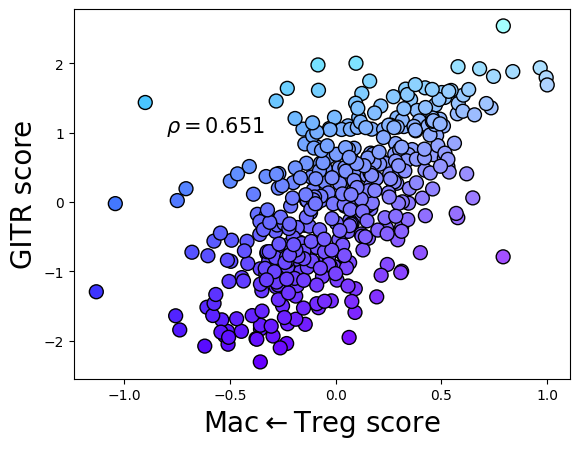

pvalue 8.815658480415124e-53 | rho=0.651


In [61]:
# set colors for the scatter plot
clr = km_data[['mac_treg_score','gitr_score']].values.copy()
clr = (clr - clr.min()) / (clr.max() - clr.min())
clr_rgba = np.ones((len(clr), 3))
clr_rgba[:,[0,1]] = clr
clr_rgba = [x.tolist() for x in clr_rgba]

# Plot
fig, ax = plt.subplots(1,1)
rho = km_data[['mac_treg_score','gitr_score']].corr('spearman').iloc[0,1]
stat_res = spearmanr(km_data['mac_treg_score'].values, km_data['gitr_score'].values)
rho = stat_res.statistic
pval = stat_res.pvalue
ax.scatter(km_data['mac_treg_score'].values,km_data['gitr_score'].values, c = clr_rgba, marker = 'o', edgecolor = 'black', s = 100)
ax.set_xlabel(r'Mac$\leftarrow$Treg score', fontsize = 20)
ax.set_ylabel('GITR score', fontsize = 20)
ax.text(-0.8, 1, r'$\rho=${:0.3f}'.format(rho), fontsize = 15)
plt.show()

print(rf'pvalue {pval} | rho={rho:0.3f}')

## Compare against CellphoneDB

In [64]:
import os
import telegraph as tg

Define path to single cell data

In [67]:
SC_DIR = '../../data/imod/scc/sc/'

Load all single cell data

In [68]:
ad_sc  = {x.split('_')[0]:ad.read_h5ad(osp.join(SC_DIR, x)) for x in os.listdir(SC_DIR)}
ad_sc = ad.concat(ad_sc)

Normalize data

In [69]:
sc.pp.normalize_total(ad_sc)
sc.pp.log1p(ad_sc)

Run CellPhoneDB

In [72]:
cpdb = tg.ext.cpdb.run(ad_sc, label_col='level3_celltype', cpdb_file_path='../../rsc/cellphonedb/cellphonedb.zip')

Reading user files...
The following user files were loaded successfully:
counts from AnnData object
/tmp/tmp81mslbjy/meta.csv
[ ][CORE][14/11/24-14:55:05][INFO] [Cluster Statistical Analysis] Threshold:0.1 Iterations:1000 Debug-seed:-1 Threads:4 Precision:3
[ ][CORE][14/11/24-14:55:07][INFO] Running Real Analysis
[ ][CORE][14/11/24-14:55:07][INFO] Running Statistical Analysis


100%|████████████████████████████████████████████████████| 1000/1000 [02:41<00:00,  6.18it/s]

[ ][CORE][14/11/24-14:57:49][INFO] Building Pvalues result


[ ][CORE][14/11/24-14:57:50][INFO] Building results
Saved deconvoluted to /tmp/tmp81mslbjy/statistical_analysis_deconvoluted_11_14_2024_145751.txt
Saved deconvoluted_percents to /tmp/tmp81mslbjy/statistical_analysis_deconvoluted_percents_11_14_2024_145751.txt
Saved means to /tmp/tmp81mslbjy/statistical_analysis_means_11_14_2024_145751.txt
Saved pvalues to /tmp/tmp81mslbjy/statistical_analysis_pvalues_11_14_2024_145751.txt
Saved significant_means to /tmp/tmp81mslbjy/statistical_analysis_significant_means_11_14_2024_145751.txt


Remove non-significant hits

In [73]:
cpdb_sig = cpdb.iloc[cpdb.pval.values < 0.05]

Get the Mac and Treg interactions

In [74]:
cpdb_mac_treg = cpdb_sig.iloc[ (cpdb_sig.target.values == 'Mac') & (cpdb_sig.source.values == 'Treg')]

Clean results from NaNs

In [75]:
cpdb_mac_treg = cpdb_mac_treg.iloc[~(cpdb_mac_treg.values == 'nan').any(axis=1)]

Get the names of the receptors and the pairs identified

In [76]:
treg_receptors = cpdb_mac_treg['receptor'].unique().tolist()
treg_ligands = cpdb_mac_treg['ligand'].unique().tolist()

Print L-R pairs

In [77]:
pairs = set([(x,y) for x,y in zip(cpdb_mac_treg['ligand'],cpdb_mac_treg['receptor'])])

In [78]:
print(f'Number of pairs {len(pairs)}')

Number of pairs 14
